## Load and Create Dataset

In [1]:
pip install google-cloud-bigquery


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [192]:

df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    edadmitdate,
    eddischargedate,
    EXTRACT(DAYOFWEEK FROM edadmitdate) AS admit_dow,
    EXTRACT(MONTH FROM edadmitdate) AS admit_month,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    edadmithour,
    eddischargehour,
    LOS_hr,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    icd_title,
    mental_health_category,
    is_readmission
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1
""")

In [193]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [194]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

### Drop Duplicates

In [195]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

### Split the Data into training and test sets

In [196]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.25,random_state=42,)

In [197]:
train_df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,admit_dow,admit_month,discharge_dow,discharge_month,...,resprate,o2sat,sbp,dbp,acuity,med_name,icd_title,mental_health_category,is_readmission,num_comorbitites
427453,12226975,38418674,<NA>,38418674,2172-04-03,2172-04-03,6,4,6,4,...,18.000000000,98.000000000,105.000000000,62.000000000,2.000000000,clozapine,NEUROTIC DISORDER NOS,Anxiety and Related Disorders,1,1
366874,16170525,30348103,20831817,30348103,2116-08-18,2116-08-18,3,8,3,8,...,16.000000000,100.000000000,147.000000000,103.000000000,2.000000000,clonidine,OPIOID/OTHER DEP-UNSPEC,Substance-Related Mental Disorders,1,2
329210,18618203,33944712,25011280,<NA>,2123-08-13,2123-08-13,6,8,6,8,...,None,None,None,None,None,Calcarb 600 With Vitamin D,ALCOH DEP NEC/NOS-UNSPEC,Substance-Related Mental Disorders,0,1
287625,12984362,31513984,23118424,<NA>,2159-10-30,2159-10-31,3,10,4,10,...,16.000000000,96.000000000,108.000000000,76.000000000,2.000000000,Depakote,MILD INTELLECTUAL DISABILITIES,Intellectual Disabilities,0,1
55380,13644769,32096086,21717320,<NA>,2173-10-24,2173-10-24,1,10,1,10,...,18.000000000,98.000000000,150.000000000,90.000000000,2.000000000,hydrochlorothiazide,PSYCHOSIS NOS,Psychotic Disorders,0,0


In [198]:
train_df.shape

(205143, 33)

### Check for NaNs

In [199]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    63750
readmit_stay_id           142051
edadmitdate                    0
eddischargedate                0
admit_dow                      0
admit_month                    0
discharge_dow                  0
discharge_month                0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    13
insurance                  21630
marital_status             12702
language                   10249
race_group                     0
temperature                 7760
heartrate                   4950
resprate                    7023
o2sat                       6448
sbp                         5330
dbp                         5924
acuity                      1129
med_name                   23289
icd_title                      0
mental_hea

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

In [200]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    63750
readmit_stay_id           142051
edadmitdate                    0
eddischargedate                0
admit_dow                      0
admit_month                    0
discharge_dow                  0
discharge_month                0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    13
insurance                  21630
marital_status             12702
language                   10249
race_group                     0
temperature                 7760
heartrate                   4950
resprate                    7023
o2sat                       6448
sbp                         5330
dbp                         5924
acuity                      1129
med_name                   23289
icd_title                      0
mental_hea

### Clean and Transform Columns

In [201]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205143 entries, 427453 to 195158
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   subject_id              205143 non-null  Int64 
 1   stay_id                 205143 non-null  Int64 
 2   hadm_id                 141393 non-null  Int64 
 3   readmit_stay_id         63092 non-null   Int64 
 4   edadmitdate             205143 non-null  dbdate
 5   eddischargedate         205143 non-null  dbdate
 6   admit_dow               205143 non-null  Int64 
 7   admit_month             205143 non-null  Int64 
 8   discharge_dow           205143 non-null  Int64 
 9   discharge_month         205143 non-null  Int64 
 10  edadmithour             205143 non-null  Int64 
 11  eddischargehour         205143 non-null  Int64 
 12  LOS_hr                  205143 non-null  Int64 
 13  arrival_transport       205143 non-null  object
 14  disposition             205143 non-n

Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [202]:
# Create a customtransofrmer for each column transformation for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Change gender column to a binary

class GenderMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_map = {'F': 0, 'M': 1}  

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'gender' in X_copy.columns:
            X_copy['gender'] = X_copy['gender'].map(self.gender_map)
        return X_copy

In [203]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
class ConvertVitalSignsToFloats(BaseEstimator, TransformerMixin):
    """
    Converts Vital Signs to Floats
    """
    def __init__(self):
        self.type = float
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        vital_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
        
        for col in vital_cols:
            if col in X_copy.columns:
                try:
                    X_copy[col] =  X_copy[col].astype(float)
                except ValueError as e:
                    print(f"[Error] Could not convert column '{col}' to float. Error: {e} converting to NaN")
                    pd.to_numeric(X_copy[col], errors='coerce')
                    
            else:
                print(f'Not Column {col} not found in list')
        return X_copy
    
class CelsiusToFahrenheit(BaseEstimator, TransformerMixin):
    """
    Converts temperature signs recorded in celsisus to fahrenheit
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        if 'temperature' in X_copy.columns:
            try:
                 # Create a mask for likely Celsius values
                mask = X_copy['temperature'] <= 38
                X_copy.loc[mask, 'temperature'] = X_copy.loc[mask, 'temperature'] * 9/5 + 32
            except ValueError as e:
                print(f"[Error] Could not convert column. Error: {e}")
        return X_copy
    

In [204]:
# Create an unmarried vs married column from marital status column
class MaritalStatusMapper(BaseEstimator, TransformerMixin):
    """
    Converts marital status to a binary variable, married/partnered vs single/ not partnered
    """
    def __init__(self):
        self.is_married_map = {'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0}

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'marital_status' in X_copy.columns:
            X_copy['marital_status'] = X_copy['marital_status'].map(self.is_married_map)
        return X_copy


In [205]:
# Feature engineer a binary variable for these races:
#  - Black/African
#  - American Indian/Alaska Native Patiants
#  - PORTUGUESE
#  - Cuban
#  - BLACK/AFRICAN AMERICAN
#  - Puerto Rican
#  - Unknown
#  - Hispanic or Latino
#  - Honduran

# print(train_df['race'].unique())
# train_df['Black/African'] = (train_df['race'] == 'BLACK/AFRICAN').astype(int)
# train_df['American Indian/Alask Native'] = (train_df['race'] == 'AMERICAN INDIAN/ALASKA NATIVE').astype(int)
# train_df['Portueguese'] = (train_df['race'] == 'PORTUGUESE').astype(int)
# train_df['Cuban'] = (train_df['race'] == 'HISPANIC/LATINO - CUBAN').astype(int)
# train_df['Puerto Rican'] = (train_df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
# train_df['African American'] = (train_df['race'] ==  'BLACK/AFRICAN AMERICAN').astype(int)
# train_df['Unknown'] = (train_df['race'] ==  'UNKNOWN').astype(int)
# train_df['Puerto Rican'] = (train_df['race'] ==  'HISPANIC/LATINO - PUERTO RICAN').astype(int)
# train_df['Hispanic or Latino'] = (train_df['race'] ==  'HISPANIC OR LATINO').astype(int)
# train_df['Honduran'] = (train_df['race'] == 'HISPANIC/LATINO - HONDURAN').astype(int)

In [206]:
# Feature engineer binary variables for Patients 50 - 59 and Patients 40 - 49
# print(train_df['age_group'].unique())
# train_df['90s'] = (train_df['age_group'] == '90+').astype(int)
# train_df['80s'] = (train_df['age_group'] == '80-89').astype(int)
# train_df['70s'] = (train_df['age_group'] == '70-79').astype(int)
# train_df['60s'] = (train_df['age_group'] == '60-69').astype(int)
# train_df['50s'] = (train_df['age_group'] == '50-59').astype(int)
# train_df['40s'] = (train_df['age_group'] == '40-49').astype(int)
# train_df['30s'] = (train_df['age_group'] == '30-39').astype(int)
# train_df['20s'] = (train_df['age_group'] == '20-29').astype(int)
# train_df['10s'] = (train_df['age_group'] == '10-19').astype(int)

In [207]:
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        return X_copy


In [208]:
from collections import defaultdict

class GetMedicationFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.med_to_freq = None
        self.freq_to_meds = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['med_name'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.med_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_meds = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_meds[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['med_name'] =  X_copy['med_name'].map(self.med_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'med_name':'med_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        med_freq_id = X_copy.groupby(['stay_id'])['med_freq_id'].sum().reset_index()
        med_freq_id.rename(columns={'med_freq_id':'sum_of_med_freq_id'},inplace=True)
        
        # Drop the old med freq id and drop duplicates
        X_copy.drop(columns=['med_freq_id'],axis=1,inplace=True)
        X_copy.drop_duplicates(inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(med_freq_id,how='left',on=['stay_id'])
        
        return X_copy
    



In [209]:
class GetLanguageFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.language_to_freq = None
        self.freq_to_language = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['language'].value_counts().to_dict()
        
        # Mapping: languages → frequency
        self.language_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of languages
        self.freq_to_language = defaultdict(set)
        for language, freq in freqs.items():
            self.freq_to_language[freq].add(language)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['language'] =  X_copy['language'].map(self.language_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'language':'language_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        language_freq_id = X_copy.groupby(['stay_id'])['language_freq_id'].sum().reset_index()
        language_freq_id.rename(columns={'language_freq_id':'sum_of_language_freq_id'},inplace=True)
        
        # Drop the old language freq id and drop duplicates
        X_copy.drop(columns=['language_freq_id'],axis=1,inplace=True)
        X_copy.drop_duplicates(inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(language_freq_id,how='left',on=['stay_id'])
        
        return X_copy

In [210]:
class GetDisposition(BaseEstimator, TransformerMixin):
    """
    Creates a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility
    """
    def __init__(self):
        self.dispositions = ['ELOPED','LEFT AGAINST MEDICAL ADVICE','LEFT WITHOUT BEING SEEN']

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # 1 if the patient left without getting proper treatment else 0
        X_copy['disposition'].apply(lambda x: 1 if x in self.dispositions else 0 )
        return X_copy

In [211]:
class GetDiagnosesFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode Patient Diagnoses and creates a summed value
    """
    def __init__(self):
        self.diagnosis_to_freq = None
        self.freq_to_diangosis = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['icd_title'].value_counts().to_dict()
        
        # Mapping: diagnosis_names → frequency
        self.diagnosis_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of diagnosis_names
        self.freq_to_diangosis = defaultdict(set)
        for diagnosis, freq in freqs.items():
            self.freq_to_diangosis[freq].add(diagnosis)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['icd_title'] =  X_copy['icd_title'].map(self.diagnosis_to_freq)
        
        # Rename the icd title column name
        X_copy.rename(columns={'icd_title':'icd_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit
        icd_freq_id = X_copy.groupby(['stay_id'])['icd_freq_id'].sum().reset_index()
        icd_freq_id.rename(columns={'icd_freq_id':'sum_of_icd_freq_id'},inplace=True)
        
        # Drop the old diangoses freq id and drop duplicates
        X_copy.drop(columns=['icd_freq_id'],inplace=True)
        X_copy.drop_duplicates(inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(icd_freq_id,how='left',on=['stay_id'])
        
        return X_copy

In [212]:
class NumericImputer(BaseEstimator, TransformerMixin):
    """
    Only imputes numeric columns
    """
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.imputer.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.imputer.transform(X_copy[self.numeric_cols])
        return X_copy

### Create Preprocessing Pipeline

In [213]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('MapGender',GenderMapper()),
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()),
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()),
        ('MaritalStatusMapper',MaritalStatusMapper()),
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()),
        ('GetMedicationFrequencies',GetMedicationFrequencies()),
        ('GetDisposition',GetDisposition()),
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()),
        ('GetLanguageFrequencies',GetLanguageFrequencies()),
        ('SimpleImputer', NumericImputer(strategy='mean'))  # Fill the nulls with the mean value for applicable features
    ]
)
train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(df)


### Describe the Data

In [214]:
train_df_cleaned.describe()

,subject_id,stay_id,hadm_id,readmit_stay_id,admit_dow,admit_month,discharge_dow,discharge_month,edadmithour,eddischargehour,...,sbp,dbp,acuity,is_readmission,num_comorbitites,total_admissions,total_discharges,sum_of_med_freq_id,sum_of_icd_freq_id,sum_of_language_freq_id
count,6.303900e+04,6.303900e+04,6.303900e+04,6.303900e+04,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,...,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,63039.000000,6.303900e+04
mean,1.506795e+07,3.500557e+07,2.501365e+07,3.501086e+07,4.006726,6.587224,4.007567,6.592601,13.263551,12.417821,...,132.235724,81.938103,2.486661,0.303050,0.587113,19.931820,19.779803,12188.158870,12115.170085,1.151921e+05
std,2.765031e+06,2.883114e+06,2.327129e+06,1.583248e+06,2.009397,3.467471,2.009643,3.466764,6.882535,6.524287,...,19.641936,81.195134,0.603887,0.459581,0.636209,27.996269,27.688723,27735.581599,14496.695538,1.119314e+05
min,1.000008e+07,3.000002e+07,2.000020e+07,3.000002e+07,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,...,1.000000,7.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000e+00
25%,1.276996e+07,3.252251e+07,2.384377e+07,3.501086e+07,2.000000,4.000000,2.000000,4.000000,9.000000,7.000000,...,119.000000,71.000000,2.000000,0.000000,0.000000,4.000000,4.000000,0.000000,2080.000000,5.311800e+04
50%,1.522957e+07,3.500729e+07,2.501365e+07,3.501086e+07,4.000000,7.000000,4.000000,7.000000,14.000000,13.000000,...,132.000000,80.000000,2.000000,0.000000,1.000000,10.000000,10.000000,542.000000,7265.000000,1.062360e+05
75%,1.738559e+07,3.749797e+07,2.620102e+07,3.501086e+07,6.000000,10.000000,6.000000,10.000000,19.000000,18.000000,...,143.000000,89.000000,3.000000,1.000000,1.000000,24.000000,24.000000,12457.000000,17302.000000,1.593540e+05
max,1.999947e+07,3.999996e+07,2.999928e+07,3.999996e+07,7.000000,12.000000,7.000000,12.000000,23.000000,23.000000,...,776.000000,9110.000000,5.000000,1.000000,5.000000,370.000000,386.000000,440500.000000,138416.000000,1.274832e+06


- There are outliers in just about every column. But, because I plan to use tree based models the outliers won't need to be removed because outliers don't impact tree based models the way they do to linear models. 

### Identify Multicolinearited Features

In [216]:
# Variables that are linearly correlated with each other may be communicating the same information. So, I can just identify them in advance and remove them from the analysis or I can combine them into one variable all together.
from statsmodels.stats.outliers_influence import variance_inflation_factor


features = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','stay_id','hadm_id','readmit_stay_id'])
X = features.values

# VIF DataFrame
vif_df = pd.DataFrame()
# calculating VIF for each feature
vif_df['feature'] = features.columns
vif_df.set_index('feature', inplace=True)
vif_df["VIF"] = [round(variance_inflation_factor(X, i),1)
                          for i,value in enumerate(features)]



<Axes: ylabel='feature'>

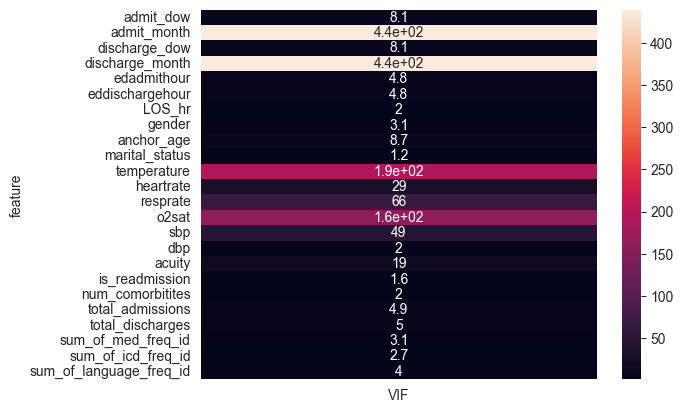

In [217]:
# Plot Heat Map
sns.heatmap(vif_df,annot=True)

It seems that admit_dow, discharge_dow, anchor_age, heartrate, resprate, sbp, acuity, all have pretty high correlations

<Axes: >

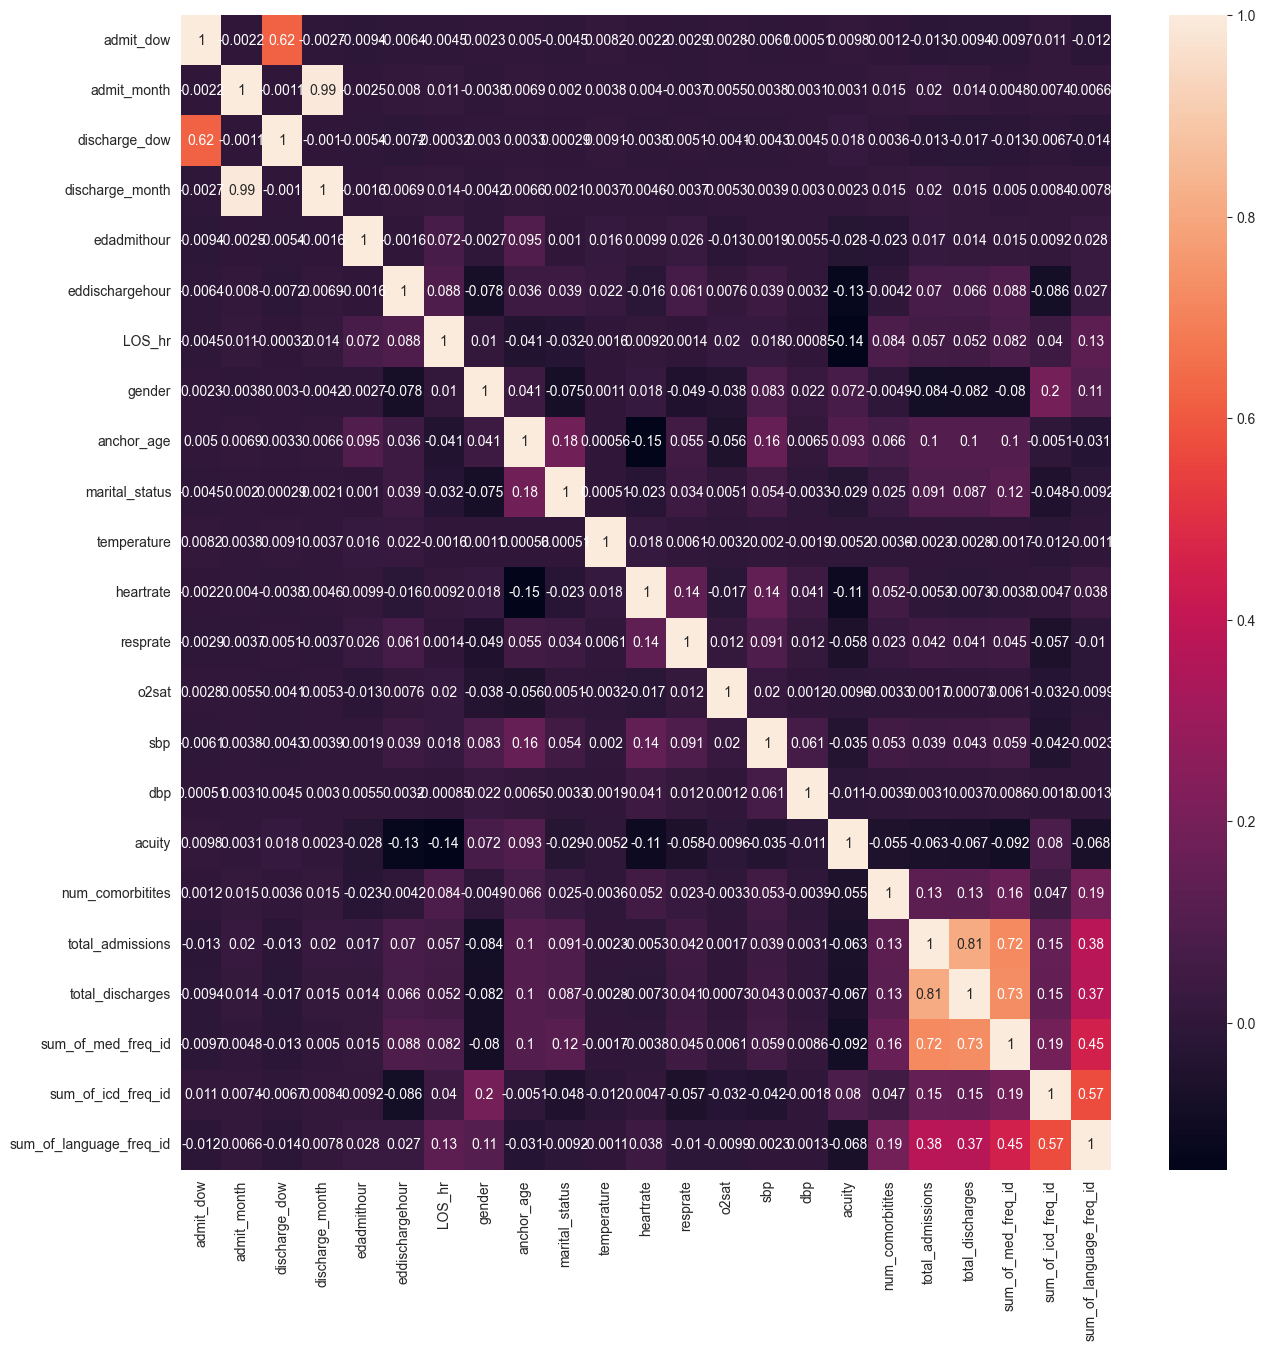

In [220]:
# Use a correlation matrix to identify which variables are correlated with one another
train_numeric = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','stay_id','hadm_id','readmit_stay_id','is_readmission'])
corr = train_numeric.corr()

# Plot heatmap
plt.figure(figsize=(18,15))
sns.heatmap(corr,annot=True)

So there are some obvious variables that are correlated with one another that I could remove:
- admit_dow and discharge_dow are highly correlated, this makes sense since a patient is likely discharged on the same day they are admitted
- admit_month and discharge month are also highly correlated
- total admissions and total discharges are hihgly correlated

In [221]:
train_df_cleaned.drop(['admit_dow','admit_month','total_admissions'],axis=1,inplace=True)

### Create Categorical Values

In [222]:
train_df_cleaned.select_dtypes(include=['object']).nunique()

arrival_transport          5
disposition                8
insurance                  5
race_group                 9
mental_health_category    11
dtype: int64

In [223]:
train_df_one_hot = pd.get_dummies(train_df_cleaned,columns=train_df_cleaned.select_dtypes(include=['object']).columns,dtype='Int64',drop_first=True)

In [224]:
train_df_one_hot

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,discharge_dow,discharge_month,edadmithour,eddischargehour,...,mental_health_category_Behavioral Syndromes,mental_health_category_Childhood and Adolescent Disorders,mental_health_category_Developmental Disorders,mental_health_category_Intellectual Disabilities,mental_health_category_Mood Disorders,mental_health_category_Organic Mental Health Disorders,mental_health_category_Personality and Behavioral Disorders,mental_health_category_Psychotic Disorders,mental_health_category_Substance-Related Mental Disorders,mental_health_category_Unspecified Mental Disorders
0,12268962.0,31211232.0,2.501365e+07,3.501086e+07,2124-08-10,2124-08-10,5.0,8.0,0.0,7.0,...,0,0,0,0,0,0,0,0,1,0
1,10184738.0,30351957.0,2.915746e+07,3.501086e+07,2161-01-02,2161-01-03,7.0,1.0,19.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,10207022.0,34910268.0,2.501365e+07,3.501086e+07,2156-09-29,2156-09-29,4.0,9.0,16.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,11208772.0,30214472.0,2.321777e+07,3.501086e+07,2177-04-25,2177-04-26,7.0,4.0,20.0,12.0,...,0,0,0,0,0,1,0,0,0,0
4,12770059.0,34837950.0,2.256134e+07,3.501086e+07,2123-12-03,2123-12-03,6.0,12.0,1.0,10.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63034,19954648.0,35550209.0,2.505039e+07,3.501086e+07,2151-01-11,2151-01-12,3.0,1.0,10.0,18.0,...,0,0,0,0,1,0,0,0,0,0
63035,18736648.0,39600698.0,2.501365e+07,3.960070e+07,2176-06-20,2176-06-20,5.0,6.0,20.0,22.0,...,0,0,0,0,0,0,0,0,1,0
63036,10479759.0,30807066.0,2.501365e+07,3.501086e+07,2120-04-02,2120-04-03,4.0,4.0,22.0,0.0,...,0,0,0,0,0,0,0,0,1,0
63037,16745245.0,39351127.0,2.501365e+07,3.501086e+07,2144-02-19,2144-02-20,5.0,2.0,23.0,2.0,...,0,0,0,0,0,0,0,0,1,0


### Feature Selection with Random Forest Model

I'm going to use a tree based model to help with model selection

In [256]:
X_train = train_df_one_hot.drop(['is_readmission','subject_id','stay_id','hadm_id','readmit_stay_id','edadmitdate','eddischargedate'],axis=1)
y_train = train_df_one_hot['is_readmission']

# Create a validation set
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=42)


In [267]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score,accuracy_score,recall_score,confusion_matrix

In [269]:

# The Random Forest Classifier is an ensemble model that trains data on random samples of the training data provided (bootstrapping). Then it
# The it uses majority votes to determine the overall output. So, it takes the classification from each of the models trained on a random sample of the data
# and selects the classification based on the majority of the models.The randomness of samples helps to reduce overfitting compared to if a single decision tree was used.


# Build a Random Forest Model
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,n_jobs=-1,random_state=42)
rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced','balanced_subsample',None] # addresses class imbalance
}

# Use Random SearchCV to find the best parameters
random_search = RandomizedSearchCV(rnd_clf, param_distributions=rnd_clf_params, cv=5, n_iter=10, n_jobs=-1, random_state=42)
random_search.fit(X_train,y_train)


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_leaf_nodes=16,
                                                    n_estimators=500, n_jobs=-1,
                                                    random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42)

In [270]:
# See how well the model fits the data by scoring it on the training data
print("Best model score on train set:", random_search.score(X_train, y_train))
# see if there is any under or over fitting by scoring the data on the validation set
print("Best model score on train set:", random_search.score(X_val, y_val))

Best model score on train set: 0.757411116178541
Best model score on train set: 0.7555520304568528


Text(0.5, 1.0, 'Confusion Matrix: Validation Data')

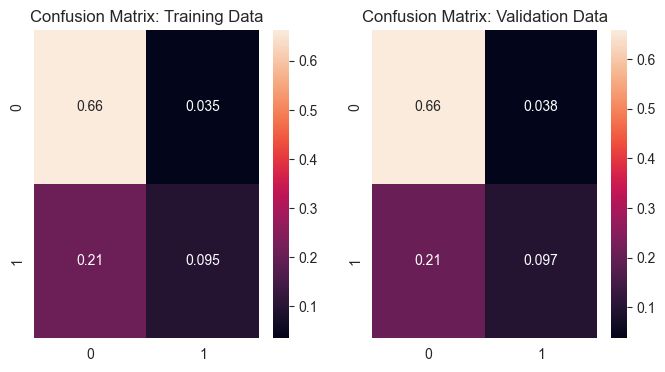

In [283]:
train_conf_matrix_rnd = confusion_matrix(y_train, random_search.predict(X_train),normalize='all')
val_conf_matrix_rnd = confusion_matrix(y_val, random_search.predict(X_val),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))

# Heatmap: Training Set
sns.heatmap(train_conf_matrix,annot=True,ax=ax1)
ax1.set_title("Confusion Matrix: Training Data")

# Heatmap: Validation Set
sns.heatmap(val_conf_matrix,annot=True,ax=ax2)
ax2.set_title("Confusion Matrix: Validation Data")

In [284]:
# Get best parameters
print(random_search.best_params_)

{'n_estimators': 1000, 'max_leaf_nodes': 20, 'max_depth': None, 'class_weight': None}


In [285]:
# Get Feature Importances
rnd_clf_optomized = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=20,n_jobs=-1,random_state=42)
rnd_clf_optomized.fit(X_train,y_train)

for score, name in zip(rnd_clf_optomized.feature_importances_,X_train.columns):
    print(name, round(score * 100,0))

eddischargehour 0.0
LOS_hr 0.0
gender 5.0
anchor_age 13.0
marital_status 11.0
o2sat 0.0
acuity 3.0
num_comorbitites 1.0
total_discharges 1.0
sum_of_med_freq_id 4.0
sum_of_icd_freq_id 21.0
sum_of_language_freq_id 21.0
disposition_ELOPED 3.0
disposition_HOME 1.0
insurance_Private 1.0
race_group_Black / African American 6.0
race_group_White 1.0
mental_health_category_Mood Disorders 0.0
mental_health_category_Substance-Related Mental Disorders 8.0


In [286]:
# Only retain the features that were most important in the models prediciton
X_train = X_train[['eddischargehour','LOS_hr','gender','anchor_age','marital_status','o2sat','acuity','num_comorbitites','total_discharges','sum_of_med_freq_id','sum_of_icd_freq_id','sum_of_language_freq_id','disposition_ELOPED','disposition_HOME','insurance_Private','race_group_Black / African American','race_group_White','mental_health_category_Mood Disorders','mental_health_category_Substance-Related Mental Disorders']]
X_val = X_val[['eddischargehour','LOS_hr','gender','anchor_age','marital_status','o2sat','acuity','num_comorbitites','total_discharges','sum_of_med_freq_id','sum_of_icd_freq_id','sum_of_language_freq_id','disposition_ELOPED','disposition_HOME','insurance_Private','race_group_Black / African American','race_group_White','mental_health_category_Mood Disorders','mental_health_category_Substance-Related Mental Disorders']]

In [287]:
# print model values with optomized hyperparameters
rnd_clf_optomized.fit(X_train,y_train)
print("Optomized RandomForest Model train set:", rnd_clf_optomized.score(X_train, y_train))
print("Optomized RandomForest Model val set:", rnd_clf_optomized.score(X_val, y_val))

Optomized RandomForest Model train set: 0.757411116178541
Optomized RandomForest Model val set: 0.7555520304568528


Using Randomized Search CV to find the best parameters, improves the model, but ever so slightly. Not enough to really produce noticable changes. 

# Testing Different Models

The Accuracy for the model seems to be relatively decent, however, I will try to see how the model performs on other tree based models. To see if I can get better performance. 

In [303]:
from sklearn.ensemble import GradientBoostingClassifier


gbrt_clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=500,
    learning_rate=1.0,
    random_state=42,
    n_iter_no_change=10 # a form of early stopping, if 20 trees doesnt help performanc the model stops
)
gbrt_clf.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=500,
                           n_iter_no_change=10, random_state=42)

In [308]:
gbrt_clf.n_estimators_

82

In [304]:
gbrt_clf.score(X_train,y_train)

0.7790842933909699

In [305]:
gbrt_clf.score(X_val,y_val)

0.7776015228426396

Text(0.5, 1.0, 'Confusion Matrix: Validation Data')

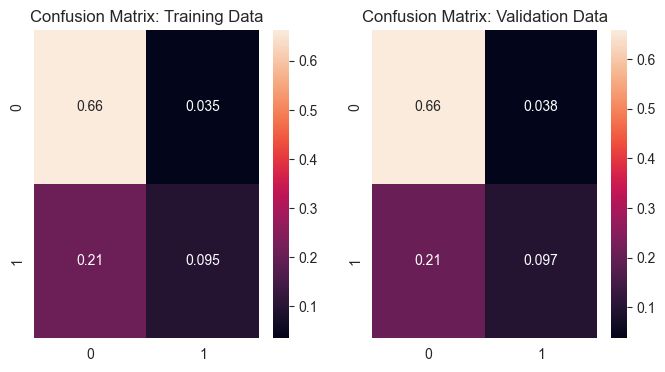

In [307]:
train_conf_matrix_gbrt = confusion_matrix(y_train, random_search.predict(X_train),normalize='all')
val_conf_matrix_gbrt = confusion_matrix(y_val, random_search.predict(X_val),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))

# Heatmap: Training Set
sns.heatmap(train_conf_matrix_gbrt,annot=True,ax=ax1)
ax1.set_title("Confusion Matrix: Training Data")

# Heatmap: Validation Set
sns.heatmap(val_conf_matrix_gbrt,annot=True,ax=ax2)
ax2.set_title("Confusion Matrix: Validation Data")

In [311]:
import xgboost as xgb
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train, y_train, eval_set=[(X_val, y_val)])


[0]	validation_0-logloss:0.56404
[1]	validation_0-logloss:0.53515
[2]	validation_0-logloss:0.51691
[3]	validation_0-logloss:0.50356
[4]	validation_0-logloss:0.49499
[5]	validation_0-logloss:0.48860
[6]	validation_0-logloss:0.48389
[7]	validation_0-logloss:0.48009
[8]	validation_0-logloss:0.47599
[9]	validation_0-logloss:0.47340
[10]	validation_0-logloss:0.47128
[11]	validation_0-logloss:0.46967
[12]	validation_0-logloss:0.46794
[13]	validation_0-logloss:0.46523
[14]	validation_0-logloss:0.46365
[15]	validation_0-logloss:0.46126
[16]	validation_0-logloss:0.46010
[17]	validation_0-logloss:0.45880
[18]	validation_0-logloss:0.45753
[19]	validation_0-logloss:0.45671
[20]	validation_0-logloss:0.45536
[21]	validation_0-logloss:0.45287
[22]	validation_0-logloss:0.45214
[23]	validation_0-logloss:0.45052
[24]	validation_0-logloss:0.44964
[25]	validation_0-logloss:0.44844
[26]	validation_0-logloss:0.44695
[27]	validation_0-logloss:0.44640
[28]	validation_0-logloss:0.44454
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=2,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [312]:
clf.score(X_train, y_train)

0.8676805932858758

In [313]:
clf.score(X_val, y_val)

0.8404187817258884

# Build Model Pipeline